<a href="https://colab.research.google.com/github/eeuunnjjiii/Franchise-Guide/blob/main/4.Modeling/4-1.Modeling_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 한글 깨짐 방지
!apt-get install fonts-nanum*
!apt-get install fontconfig
import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

# 화질 선명하게 설정
%config InlineBackend.figure_format='retina'

# DataFrame 컬럼 전체보기 설정
pd.set_option('display.max_columns', None) 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-gothic-light' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20170925-1).
fonts-nanum-coding is already the newest version (2.5-1).
fonts-nanum-eco is already the newest version (1.000-6).
fonts-nanum-extra is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fontconfig is already the newest version (2.12.6-0ubuntu2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
NanumGothic Eco


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [99]:
# 데이터 가져오기
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/franchise_data/total_eda.csv', index_col=0).reset_index(drop=True)

# 1. 모델 타겟 값 생성

- 모델 타겟 값 : 업종별 평균 매출액 이상 "1" / 평균 미만 "0" 으로 분류

In [100]:
# 평가 컬럼 생성
avg = df.groupby(['업종','기준년도']).mean().reset_index()[['업종','기준년도','가맹점평균매출액']] ## 업종 & 기준년도별 가맹점 평균 매출액 
avg.columns = ['업종','기준년도','업종_기준년도_평균매출액']

df = df.merge(avg, on=['업종','기준년도']) # 업종별 평균매출액 merge

df['평가'] = (df['가맹점평균매출액']>=df['업종_기준년도_평균매출액'])
df['평가'] = df['평가'].astype(int) #0:평균보다 낮음, 1:평균보다 높음

#2. 기준모델

In [101]:
# 타겟지정
target = '평가'

#타겟 비율 확인
df[target].value_counts(normalize=True) ## 불균형한 데이터

0    0.61847
1    0.38153
Name: 평가, dtype: float64

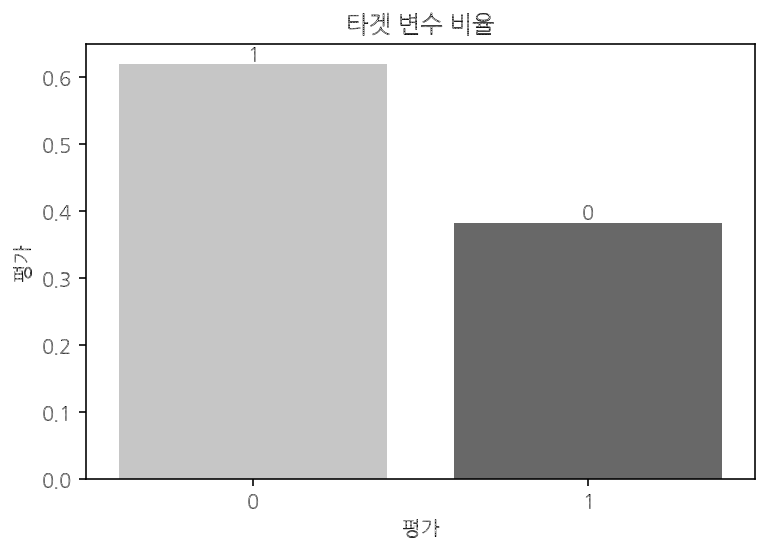

In [102]:
ax= sns.barplot(x=df[target], y=df[target].value_counts(normalize=True), palette='Greys')

for p in ax.patches:
  ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.title('타겟 변수 비율');

In [103]:
# 기준모델 생성
major = df[target].mode()[0]

# 타겟 샘플 수 만큼 0이 담긴 리스트를 만들어 기준모델로 예측
y_pred=[major]*len(df[target])

from sklearn.metrics import accuracy_score
print('기준모델 정확도 :',accuracy_score(df[target],y_pred))

기준모델 정확도 : 0.6184700372282935


#3. 데이터 분리

In [104]:
#Hold-out 방식으로 훈련, 검증, 테스트 데이터셋 분리 (타겟데이터 비율 맞추기)
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,train_size=0.8, test_size=0.2, stratify=df[target],random_state=2)
train,val = train_test_split(train,train_size=0.8, test_size=0.2, stratify=train[target],random_state=2)

train.shape, val.shape, test.shape

((5328, 38), (1333, 38), (1666, 38))

In [105]:
#데이터 특성/타겟 분리

features=train.drop(columns=[target]).columns

X_train=train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

#4. 특성 줄이기

In [106]:
def remove_feature(df):
    
    # 정보공개서에서 쉽게 열람할 수 없는 특성 삭제
    df = df.drop(['부채비율','자기자본비율','영업이익률','매출액순이익률','자기자본순이익률','폐점','폐업률'],axis=1)

    # data leakage 특성 제거
    df = df.drop(['가맹점평균매출액', '면적당평균매출액', '업종_기준년도_평균매출액'],axis=1)

    # data cardinality 높은 특성 제거
    df =df.drop(['브랜드','상호'], axis=1)
    
    # 중복되는 특성 제거
    df = df.drop(['면적당인테리어비용','기준년도','가맹사업개시일'],axis=1)
    
    # 합계(가맹비+교육비+보증금+기타비용)에 해당되는 특성 제거
    df = df.drop(['가맹비','교육비','보증금','기타비용'],axis=1)

    return df

X_train=remove_feature(X_train)
X_val=remove_feature(X_val)
X_test=remove_feature(X_test)

#5. 머신러닝 적용

##1) RandomForest 모델

In [79]:
!pip install category_encoders

In [94]:
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Standardscaler 사용 모델
pipe1=make_pipeline(TargetEncoder(), ## target에 맞춰 범주형 인코딩
                   StandardScaler(), ## 변수들 간 스케일 조정(평균0, 분산1)
                   RandomForestClassifier(n_jobs=-1,class_weight='balanced',random_state=2)) ## 가장 기본모델

pipe1.fit(X_train,y_train)
print('검증 데이터 스코어(StandardScaler):',pipe1.score(X_val,y_val))

# Robustscaler 사용 모델
pipe2=make_pipeline(TargetEncoder(), ## target에 맞춰 범주형 인코딩
                   RobustScaler(), ## 이상치에 강함 (평균과 분산 대신 중앙값과 사분위값 사용)
                   RandomForestClassifier(n_jobs=-1,class_weight='balanced',random_state=2)) ## 가장 기본모델

pipe2.fit(X_train,y_train)
print('검증 데이터 스코어(RobustScaler):',pipe2.score(X_val,y_val))

# Minmaxscaler 사용 모델
pipe3=make_pipeline(TargetEncoder(), ## target에 맞춰 범주형 인코딩
                   MinMaxScaler(), ## 원데이터 분포 유지하면서 정규화
                   RandomForestClassifier(n_jobs=-1,class_weight='balanced',random_state=2)) ## 가장 기본모델

pipe3.fit(X_train,y_train)
print('검증 데이터 스코어(MinMaxScaler):',pipe3.score(X_val,y_val))

검증 데이터 스코어(StandardScaler): 0.7786946736684172
검증 데이터 스코어(RobustScaler): 0.7786946736684172
검증 데이터 스코어(MinMaxScaler): 0.7711927981995499


- 가장 스코어가 더 높은 RobustScaler 사용

In [95]:
# 다른 성능지표 확인
from sklearn.metrics import roc_auc_score, f1_score, precision_score
from sklearn.metrics import classification_report
y_pred=pipe2.predict(X_val)
y_val_pred_proba=pipe2.predict_proba(X_val)[:,1]
print('검증 데이터 Accuracy:', round(accuracy_score(y_val,y_pred),2))
print('검증 데이터 AUC score :', round(roc_auc_score(y_val, y_val_pred_proba),2))
print('검증 데이터 F1 score :', round(f1_score(y_val, y_pred),2))
print(classification_report(y_val, y_pred))

검증 데이터 Accuracy: 0.78
검증 데이터 AUC score : 0.85
검증 데이터 F1 score : 0.67
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       824
           1       0.78      0.59      0.67       509

    accuracy                           0.78      1333
   macro avg       0.78      0.74      0.75      1333
weighted avg       0.78      0.78      0.77      1333



##2) XGBoost 모델

In [96]:
#불균형 데이터이므로 ratio 추가
ratio = y_train.value_counts(normalize=True)[1]/y_train.value_counts(normalize=True)[0]
ratio

0.616504854368932

In [97]:
from xgboost import XGBClassifier

pipe_xg=make_pipeline(TargetEncoder(),
                      RobustScaler(),
                      XGBClassifier(n_jobs=-1, random_state=2, scale_pos_weight=ratio))

pipe_xg.fit(X_train,y_train);

In [98]:
# 성능지표 확인
y_pred=pipe_xg.predict(X_val)
y_val_pred_proba=pipe_xg.predict_proba(X_val)[:,1]
print('검증 데이터 Accuracy:', round(accuracy_score(y_val,y_pred),2))
print('검증 데이터 AUC score :', round(roc_auc_score(y_val, y_val_pred_proba),2))
print('검증 데이터 F1 score :', round(f1_score(y_val, y_pred),2))
print(classification_report(y_val, y_pred))

검증 데이터 Accuracy: 0.74
검증 데이터 AUC score : 0.82
검증 데이터 F1 score : 0.56
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       824
           1       0.82      0.43      0.56       509

    accuracy                           0.74      1333
   macro avg       0.77      0.68      0.69      1333
weighted avg       0.76      0.74      0.72      1333



- 모든 평가지표에서 더 나은 성능을 보인 RandomForest 모델 선택

##3) RandomForest 모델 하이퍼파라미터 수정

###3-1) RandomizedSearchCV

In [85]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipe=make_pipeline(TargetEncoder(),
                   RobustScaler(),
                   RandomForestClassifier(n_jobs=-1,class_weight='balanced',random_state=2)) ## 가장 기본모델

# 하이퍼파라미터 범위 지정

dists={
    'targetencoder__smoothing' : [1.,10.,50.,100.,500.],
    'targetencoder__min_samples_leaf' : randint(1,50),
    'robustscaler__quantile_range':[(25.0,75.0),(10.0,90.0),(1.0,99.0)],
    'randomforestclassifier__n_estimators' : randint(1,500),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__max_features' : uniform(0,1)
}

# 시행
clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=5, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1,
    random_state=2
    )

clf.fit(X_train, y_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 14.3min finished


In [107]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('score: ', clf.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.5356041734976563, 'randomforestclassifier__n_estimators': 327, 'robustscaler__quantile_range': (1.0, 99.0), 'targetencoder__min_samples_leaf': 7, 'targetencoder__smoothing': 100.0}
score:  0.6990198361977372


###3-2) GridSearchCV

In [108]:
from sklearn.model_selection import GridSearchCV

pipe=make_pipeline(TargetEncoder(), 
                   RobustScaler(quantile_range=(1.0,99.0)), 
                   RandomForestClassifier(n_jobs=-1,class_weight='balanced',random_state=2, max_features=0.2046486340378425))

# 하이퍼파라미터 범위 지정

dists={
    'targetencoder__smoothing' : [90., 100., 110.],
    'targetencoder__min_samples_leaf' : [6, 7, 8],
    'randomforestclassifier__n_estimators' : [213, 214, 215],
    'randomforestclassifier__max_depth': [9, 10, 11],
}

grid = GridSearchCV(
    pipe, 
    param_grid=dists, 
    cv=3, 
    scoring='f1',
    verbose=1,  
    n_jobs=-1
)

grid.fit(X_train, y_train);

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  4.9min finished


In [110]:
print('최적 하이퍼파라미터: ', grid.best_params_)
print('score: ', grid.best_score_)

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 11, 'randomforestclassifier__n_estimators': 214, 'targetencoder__min_samples_leaf': 6, 'targetencoder__smoothing': 90.0}
score:  0.6793181940994776


## 4) 최종 모델

In [112]:
# 최적 모델 생성
y_pred = clf.predict(X_val)
y_val_pred_proba = clf.predict_proba(X_val)[:,1]

print('검증 데이터 Accuracy:', round(accuracy_score(y_val,y_pred),2))
print('검증 데이터 AUC score :', round(roc_auc_score(y_val, y_val_pred_proba),2))
print('검증 데이터 F1 score :', round(f1_score(y_val, y_pred),2))

검증 데이터 Accuracy: 0.76
검증 데이터 AUC score : 0.85
검증 데이터 F1 score : 0.69


- 실제 Negative 음성인 데이터 예측을 Positive 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우 -> 정밀도가 상대적으로 더 중요한 지표
- 정밀도가 더 중요! 실제 가맹점 평균 매출액 이하인데, 이상이라고 판단하는게 더 큰 영향

In [114]:
# test data 확인
y_pred = clf.predict(X_test)
y_test_pred_proba = clf.predict_proba(X_test)[:,1]

print('테스트 데이터 Accuracy:', round(accuracy_score(y_test,y_pred),2))
print('테스트 데이터 AUC score :', round(roc_auc_score(y_test, y_test_pred_proba),2))
print('테스트 데이터 F1 score :', round(f1_score(y_test, y_pred),2))
print(classification_report(y_test, y_pred))

테스트 데이터 Accuracy: 0.77
테스트 데이터 AUC score : 0.84
테스트 데이터 F1 score : 0.71
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1030
           1       0.69      0.72      0.71       636

    accuracy                           0.77      1666
   macro avg       0.76      0.76      0.76      1666
weighted avg       0.77      0.77      0.77      1666



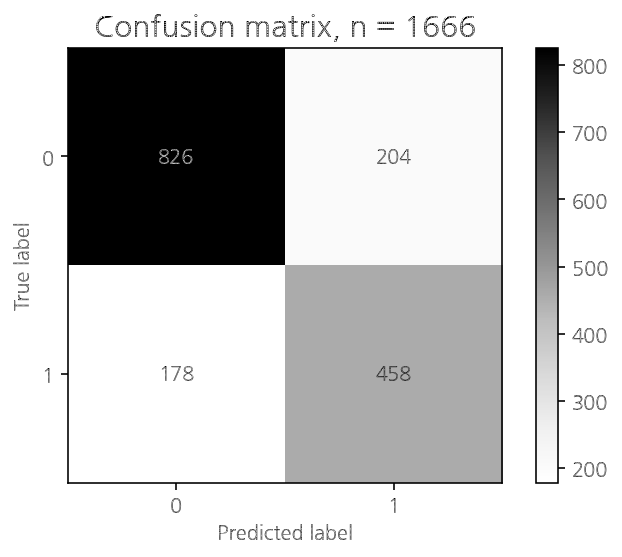

In [121]:
# Confusion Matrix 확인
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots()
pcm = plot_confusion_matrix(clf, X_test, y_test, ax=ax, cmap='Greys', values_format = '')
plt.title(f'Confusion matrix, n = {len(y_test)}', fontsize=15)
plt.show()

#6. 모델 해석

##1)  permutation importance : 특성 중요도

In [122]:
!pip install eli5

     |████████████████████████████████| 106 kB 5.2 MB/s 


In [126]:
import eli5
from eli5.sklearn import PermutationImportance

permuter=PermutationImportance(clf, scoring='f1',n_iter=5,random_state=2)

encoder = TargetEncoder(min_samples_leaf=7, smoothing=100.0)
X_train_encoded = encoder.fit_transform(X_train,y_train)
X_test_encoded = encoder.transform(X_test)
permuter.fit(X_test_encoded,y_test);

In [127]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=X_test.columns.tolist()
)

Weight,Feature
0.2088 ± 0.0221,합계
0.0217 ± 0.0055,총인테리어비용
0.0203 ± 0.0080,가맹사업일수
0.0187 ± 0.0095,당기순이익
0.0169 ± 0.0074,기준면적
0.0136 ± 0.0058,영업이익
0.0120 ± 0.0136,매출액
0.0080 ± 0.0070,가맹본부임직원수
0.0077 ± 0.0072,계약종료
0.0055 ± 0.0092,부채


- 분류 모델에서 가장 중요한 특성은 합계, 총인테리어비용, 가맹사업일수 순